In [1]:
# ✅ 필수 라이브러리 설치
!pip install --upgrade gspread oauth2client scikit-learn pandas matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [6]:
# 첫 번째 줄(헤더) 확인
header_row = grd_ws.row_values(1)

print("📌 헤더 목록:")
print(header_row)

# 중복된 헤더 체크
from collections import Counter
duplicates = [k for k, v in Counter(header_row).items() if v > 1]
print("\n⚠️ 중복된 헤더:", duplicates)


📌 헤더 목록:
['계약번호', '계약자', '최종납입월', '납입방법', '모집보험료', '유지보험료', '수정보험료', '구분', '취급자사번', '코드2', '성명', '취급자', '대리점명', '코드1', '성명2', '코드2', '핸드폰번호']

⚠️ 중복된 헤더: ['코드2']


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
# 1. 나눔글꼴 설치
!apt -qq -y install fonts-nanum

# 2. 런타임 재시작 없이 설정 적용
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd

# 3. 설치된 나눔 글꼴 경로 설정
fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name()
plt.rc('font', family=font_name)

# 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

print(f"✅ 설정된 한글 폰트: {font_name}")


fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
✅ 설정된 한글 폰트: NanumGothic


In [13]:
# 📌 인증 및 시트 연동
from google.colab import drive
drive.mount('/content/drive')

import gspread
import pandas as pd
import numpy as np
from oauth2client.service_account import ServiceAccountCredentials
from collections import Counter

# 인증 파일 경로
json_keyfile_path = "/content/drive/My Drive/Key/credentials.json"
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# 스프레드시트 열기
spreadsheet = client.open_by_url("https://docs.google.com/spreadsheets/d/1nnF6MbnaogDSc7hA_bPsDxLZHBDniR-DQ3pjbzxDP4U")
grd_ws = spreadsheet.worksheet("grd_prsList")
sheet1_ws = spreadsheet.worksheet("Sheet1")

# ✅ 헤더 자동 고유화 함수
def make_unique(headers):
    counts = Counter()
    new_headers = []
    for h in headers:
        counts[h] += 1
        if counts[h] == 1:
            new_headers.append(h)
        else:
            new_headers.append(f"{h}_{counts[h]}")
    return new_headers

# ✅ 시트 로딩 함수 (중복 헤더 자동 처리)
def load_worksheet_with_unique_headers(ws):
    rows = ws.get_all_values()
    if not rows:
        return pd.DataFrame()
    headers = make_unique(rows[0])
    data = rows[1:]
    df = pd.DataFrame(data, columns=headers)
    return df

# ✅ 시트 데이터 불러오기
grd_df = load_worksheet_with_unique_headers(grd_ws)
sheet1_df = load_worksheet_with_unique_headers(sheet1_ws)

# ✅ grd_prsList 기준: 병합 키 추출
key_cols_grd = ['코드1', '코드2', '성명']  # 고유화된 이름이 아니면 그대로 사용
key_cols_sheet1 = ['코드1', '코드2', '성명']

# 병합 (grd 기준으로 Sheet1에서 가져오기)
merged_df = pd.merge(
    grd_df,
    sheet1_df,
    left_on=key_cols_grd,
    right_on=key_cols_sheet1,
    how='left',
    suffixes=('', '_from_sheet1')
)

# ✅ M~Q열: grd 원본에서 13~17번째 컬럼 이름
cols_to_fill = grd_df.columns[12:17]

# Sheet1에서 가져온 컬럼으로 채움
for col in cols_to_fill:
    source_col = f"{col}_from_sheet1"
    if source_col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(merged_df[source_col])

# ✅ 매핑 여부 추가
first_fill_col = f"{cols_to_fill[0]}_from_sheet1"
merged_df['매핑여부'] = np.where(merged_df[first_fill_col].notnull(), '매핑됨', '매핑 안 됨')

# 보조 컬럼 제거
merged_df.drop(columns=[f"{col}_from_sheet1" for col in cols_to_fill if f"{col}_from_sheet1" in merged_df.columns], inplace=True)

# ✅ 새로운 시트로 저장
result_sheet_name = "매핑결과_자동"
try:
    spreadsheet.del_worksheet(spreadsheet.worksheet(result_sheet_name))
except:
    pass  # 없으면 넘어가기

new_ws = spreadsheet.add_worksheet(title=result_sheet_name, rows=str(len(merged_df)+10), cols="30")
new_ws.update([merged_df.columns.values.tolist()] + merged_df.values.tolist())

print("✅ '매핑결과_자동' 시트에 매핑 완료되었습니다!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ '매핑결과_자동' 시트에 매핑 완료되었습니다!


In [16]:
# ✅ '매핑결과_자동' 시트 불러오기
result_ws = spreadsheet.worksheet("매핑결과_자동")

# ✅ 중복 헤더 자동 정리해서 DataFrame으로 불러오기
def load_worksheet_with_unique_headers(ws):
    rows = ws.get_all_values()
    from collections import Counter
    def make_unique(headers):
        counts = Counter()
        new_headers = []
        for h in headers:
            counts[h] += 1
            new_headers.append(h if counts[h] == 1 else f"{h}_{counts[h]}")
        return new_headers
    headers = make_unique(rows[0])
    return pd.DataFrame(rows[1:], columns=headers)

result_df = load_worksheet_with_unique_headers(result_ws)

# ✅ 매핑 결과 분리
mapped_df = result_df[result_df['매핑여부'] == '매핑됨'].copy()
not_mapped_df = result_df[result_df['매핑여부'] == '매핑 안 됨'].copy()

print(f"✔️ 매핑된 행 수: {len(mapped_df)}")
print(f"❌ 매핑 안 된 행 수: {len(not_mapped_df)}")

# ✅ 기존 시트 삭제 (있으면)
for sheet_name in ['매핑됨', '매핑안됨']:
    try:
        spreadsheet.del_worksheet(spreadsheet.worksheet(sheet_name))
    except:
        pass  # 시트 없으면 무시

# ✅ 새 시트 생성 및 데이터 업데이트
def save_df_to_sheet(sheet_name, df):
    ws = spreadsheet.add_worksheet(title=sheet_name, rows=str(len(df)+10), cols=str(len(df.columns)))
    ws.update([df.columns.tolist()] + df.values.tolist())

save_df_to_sheet("매핑됨", mapped_df)
save_df_to_sheet("매핑안됨", not_mapped_df)

print("📄 '매핑됨'과 '매핑안됨' 시트에 각각 저장 완료!")


✔️ 매핑된 행 수: 676
❌ 매핑 안 된 행 수: 117
📄 '매핑됨'과 '매핑안됨' 시트에 각각 저장 완료!


In [14]:
# ✅ 한글 폰트 설치 (나눔 폰트)
!apt -qq -y install fonts-nanum > /dev/null

# ✅ matplotlib에 한글폰트 적용
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')  # 또는 'NanumGothic'

# ✅ 마이너한 경고 제거
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54609 (\N{HANGUL SYLLABLE PING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

🔍 총 데이터 수: 793
✅ 매핑됨: 676건 (85.25%)
❌ 매핑 안 됨: 117건 (14.75%)

📉 열별 결측치 비율:
      1.0
_2    1.0
dtype: float64


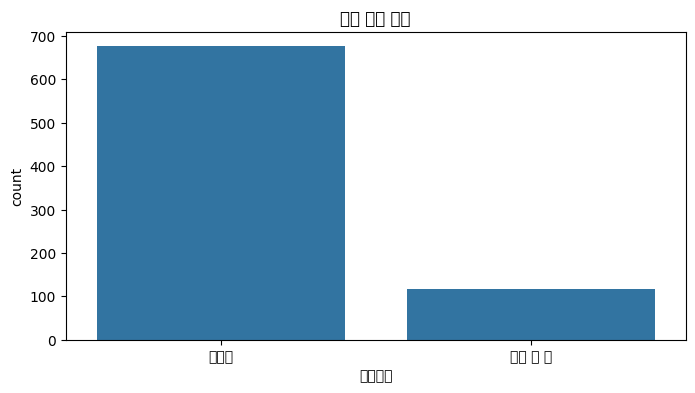

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

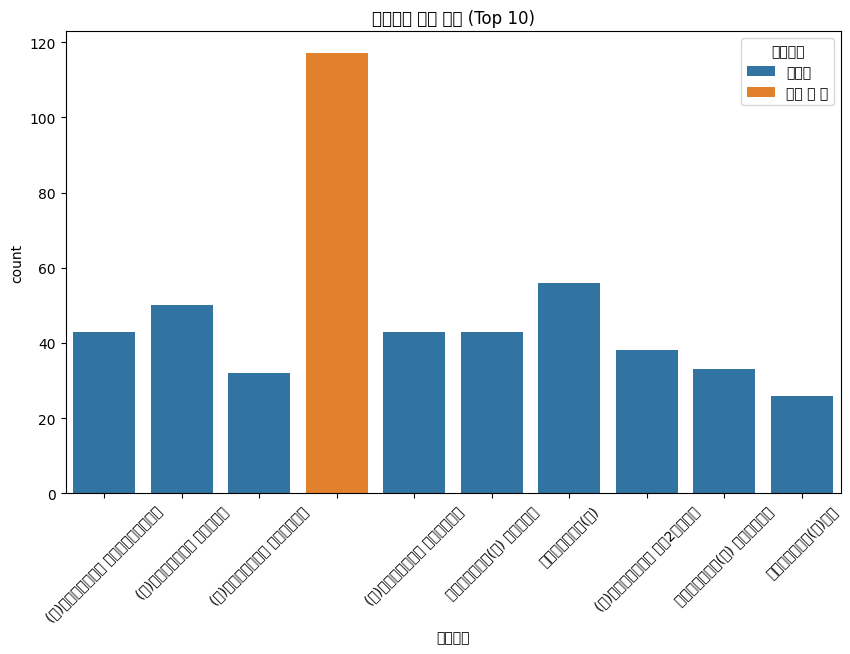

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

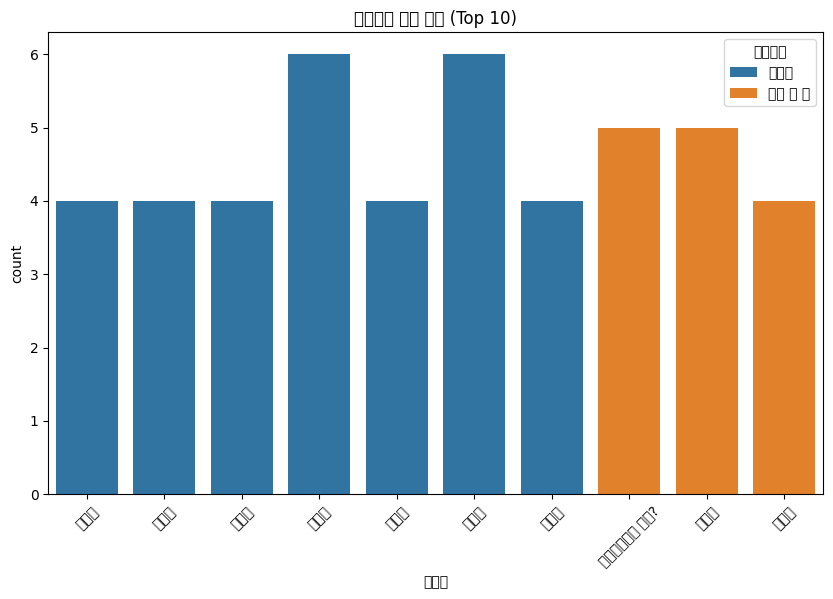

In [15]:
# 📌 결과 시트 불러오기
result_ws = spreadsheet.worksheet("매핑결과_자동")

# 데이터프레임으로 변환
result_df = load_worksheet_with_unique_headers(result_ws)

# 🧼 전처리: 숫자형 가능 컬럼은 숫자로
for col in result_df.columns:
    try:
        result_df[col] = pd.to_numeric(result_df[col])
    except:
        pass

# ✅ 1. 매핑 통계 요약
total = len(result_df)
mapped = (result_df['매핑여부'] == '매핑됨').sum()
not_mapped = total - mapped

print(f"🔍 총 데이터 수: {total}")
print(f"✅ 매핑됨: {mapped}건 ({mapped/total:.2%})")
print(f"❌ 매핑 안 됨: {not_mapped}건 ({not_mapped/total:.2%})")

# ✅ 2. 열별 결측치 비율
print("\n📉 열별 결측치 비율:")
null_ratio = result_df.isnull().mean().sort_values(ascending=False)
print(null_ratio[null_ratio > 0])

# ✅ 3. 매핑여부별 성명/코드1 등 분포 비교
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(data=result_df, x='매핑여부')
plt.title("매핑 여부 분포")
plt.show()

# 예시: '대리점명' 컬럼이 있다면 매핑여부별 분포
if '대리점명' in result_df.columns:
    top_agents = result_df['대리점명'].value_counts().nlargest(10).index
    filtered = result_df[result_df['대리점명'].isin(top_agents)]

    plt.figure(figsize=(10,6))
    sns.countplot(data=filtered, x='대리점명', hue='매핑여부')
    plt.title("대리점별 매핑 여부 (Top 10)")
    plt.xticks(rotation=45)
    plt.show()

# ✅ 4. 계약자별 매핑 상태도 (선택)
if '계약자' in result_df.columns:
    top_clients = result_df['계약자'].value_counts().nlargest(10).index
    filtered = result_df[result_df['계약자'].isin(top_clients)]

    plt.figure(figsize=(10,6))
    sns.countplot(data=filtered, x='계약자', hue='매핑여부')
    plt.title("계약자별 매핑 여부 (Top 10)")
    plt.xticks(rotation=45)
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44648 (\N{HANGUL SYLLABLE GGAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50506 (\N{HANGUL SYLLABLE ANH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

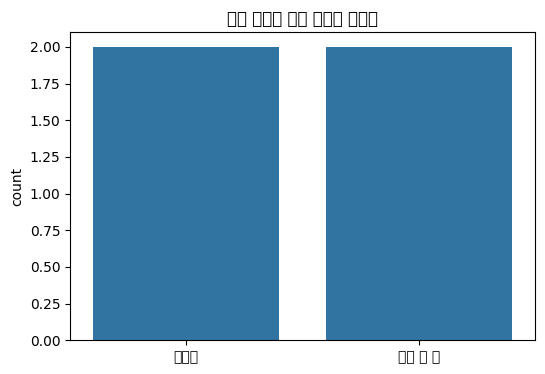

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=['매핑됨', '매핑 안 됨', '매핑됨', '매핑 안 됨'])
plt.title("한글 깨지지 않는 테스트 그래프")
plt.show()
